![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/finance-nlp/05.2.Financial_NER_Additional_Examples.ipynb)

# Identifying Entities in Financial Texts

In this notebook, you will learn how to use Spark NLP and Finance NLP to identify relevant entities in financial texts using our state-of-the-art Named-Entity Recognition (NER) models.

## Named-Entity Recognition

Named-Entity Recognition (NER) is the capability to automatically identify relevant entities in the text. For example, person names, company names, public companies trading code, quantities, etc. There are many ways to implement NER, but nowadays the most efficient one is to use models based on deep learning.

At John Snow Labs, we are proud to have a library of state-of-the-art pretrained, out-of-the-box, NLP models. With our newer package Finance NLP it is no difference, and we curetly support more than 100 models fine tuned for the financial domain. Specifically to NER, we currently have more than 30 models that can identify entities for different business needs.


Example models:

| title                                                   | language   | predicted_entities                                                                                                                                                                           | compatible_editions                |
|:--------------------------------------------------------|:-----------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------|
| Generic Deidentification NER                            | en         | ['AGE', 'CITY', 'COUNTRY', 'DATE', 'EMAIL', 'FAX', 'LOCATION-OTHER', 'ORG', 'PERSON', 'PHONE', 'PROFESSION', 'STATE', 'STREET', 'URL', 'ZIP']                                                | ['Finance NLP 1.0', 'Finance NLP'] |
| Extract Tickers on Financial Texts (RoBerta)            | en         | ['TICKER']                                                                                                                                                                                   | ['Finance NLP 1.0', 'Finance NLP'] |
| Extract Tickers on Financial Texts                      | en         | ['TICKER']                                                                                                                                                                                   | ['Finance NLP 1.0', 'Finance NLP'] |
| Extract Financial, Legal and Generic Entities in Arabic | ar         | ['NORP', 'PERS', 'LOC', 'MONEY', 'TIME', 'ORG', 'WEBSITE', 'ORDINAL', 'PERCENT', 'EVENT', 'QUANTITY', 'OCC', 'LANGUAGE', 'CARDINAL', 'DATE', 'GPE', 'PRODUCT', 'CURR', 'FAC', 'UNIT', 'LAW'] | ['Finance NLP 1.0', 'Finance NLP'] |
| Financial 10K Filings NER                               | en         | ['ADDRESS', 'CFN', 'FISCAL_YEAR', 'IRS', 'ORG', 'PHONE', 'STATE', 'STOCK_EXCHANGE', 'TICKER', 'TITLE_CLASS', 'TITLE_CLASS_VALUE']                                                            | ['Finance NLP 1.0', 'Finance NLP'] |
| Financial ORG, PRODUCT and ALIAS NER (Large)            | en         | ['ORG', 'PROD', 'ALIAS']                                                                                                                                                                     | ['Finance NLP 1.0', 'Finance NLP'] |
| Financial NER (Headers / Subheaders)                    | en         | ['HEADER', 'SUBHEADER']                                                                                                                                                                      | ['Finance NLP 1.0', 'Finance NLP'] |
| Financial Job Titles NER                                | en         | ['ROLE']                                                                                                                                                                                     | ['Finance NLP 1.0', 'Finance NLP'] |
| Financial ORG, PER, ROLE, DATE NER                      | en         | ['ORG', 'PER', 'DATE', 'ROLE']                                                                                                                                                               | ['Finance NLP 1.0', 'Finance NLP'] |
| Generic NER on Financial Texts                          | en         | ['ORG', 'LOC', 'PER']                                                                                                                                                                        | ['Finance NLP 1.0', 'Finance NLP'] |


For the complete list, check the [NLP Models Hub](https://nlp.johnsnowlabs.com/models).

## Environment Setup

First, you need to setup the environment to be able to use the licensed package. If you are not running in Google Colab, please check the documentation [here](https://nlp.johnsnowlabs.com/docs/en/licensed_install).

# Installation

In [ ]:
! pip install -q johnsnowlabs

## Automatic Installation
Using [my.johnsnowlabs.com](https://my.johnsnowlabs.com/) SSO

In [ ]:
from johnsnowlabs import nlp, finance

# nlp.install(force_browser=True)

## Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to [my.johnsnowlabs.com](https://my.johnsnowlabs.com/)
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

- Install it

In [ ]:
nlp.install()

Also, let's install some tools to display PDF files that will be used on examples.

In [ ]:
! apt-get install poppler-utils

In [ ]:
! pip install pdf2image

## Start Spark Session

In [ ]:
from johnsnowlabs import nlp, finance, viz
# Automatically load license data and start a session with all jars user has access to
spark = nlp.start()

In [ ]:
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pyspark.sql as SQL
from pyspark import keyword_only

## NerModel annotator

The deep neural network architecture for NER model in Spark NLP is BiLSTM-CNN-Char framework. It's a slightly modified version of the architecture proposed by Jason PC Chiu and Eric Nichols ([Named Entity Recognition with Bidirectional LSTM-CNNs](https://arxiv.org/abs/1511.08308)). A neural network architecture that automatically detects word and character-level features using a hybrid bidirectional LSTM and CNN architecture, eliminating the need for most feature engineering steps. This model is implemented in our `NerDL`/`NerModel` annotators that we will experiment with in this section.

To use NER models, you need the transform the data into the document class, then split the text into sentences to reduce its size, then split each token of the sentence and transform them into embedding vectors. Then you can apply the NER model and use the `NerConverterInternal` for cleaner version of the entities. Let's create a function that will define the spark pipeline with the requested model!

Since the models work with the embeddings they were trained with, the function will have three parameters to create the pipeline:

- `ner_model`, with the name of the pretrained model we want to load
- `embeddings`, with the name of the embedding model required by the ner model
- `language`, containing the code of the language of the embedding and ner model (defaults to `en`)

In [ ]:
def create_pipeline(ner_model, embeddings, language="en"):
    documentAssembler = documentAssembler = (
        nlp.DocumentAssembler().setInputCol("text").setOutputCol("document")
    )

    # Consider using SentenceDetector with rules/patterns to get smaller chunks from long sentences
    sentence_detector = (
        nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl", "xx")
        .setInputCols(["document"])
        .setOutputCol("sentence")
    )

    tokenizer = (
        nlp.Tokenizer()
        .setInputCols(["sentence"])
        .setOutputCol("token")
        .setContextChars(['.', ',', ';', ':', '!', '?', '*', '-', '(', ')', '”', '’', '$','€'])
    )

    embeddings = (
        nlp.BertEmbeddings.pretrained(embeddings, language)
        .setInputCols(["sentence", "token"])
        .setOutputCol("embeddings")
        .setMaxSentenceLength(512)
    )

    ner_model = (
        finance.NerModel.pretrained(ner_model, language, "finance/models")
        .setInputCols(["sentence", "token", "embeddings"])
        .setOutputCol("ner")
    )

    ner_converter = (
        finance.NerConverterInternal()
        .setInputCols(["sentence", "token", "ner"])
        .setOutputCol("ner_chunk")
    )

    nlpPipeline = nlp.Pipeline(
        stages=[
            documentAssembler,
            sentence_detector,
            tokenizer,
            embeddings,
            ner_model,
            ner_converter,
        ]
    )

    empty_data = spark.createDataFrame([[""]]).toDF("text")

    model = nlpPipeline.fit(empty_data)
    return model

> Please note that we added special characters in the tokenizer step in order to propertly identify some financial tokens. In special, the chars `$` or other currency chars are important. 

### Application: Identify financial entities in SEC 10K fillings

We will use our pretrained models to extract information from sections of a 10-K filling report. For example, we will use the report from the company AMD, available [here](https://ir.amd.com/sec-filings/filter/annual-filings?year=2022).

In [ ]:
link = "https://ir.amd.com/sec-filings/filter/annual-filings/content/0000002488-22-000016/0000002488-22-000016.pdf"

In [ ]:
! wget $link -O 10k_report.pdf

--2023-01-23 18:46:31--  https://ir.amd.com/sec-filings/filter/annual-filings/content/0000002488-22-000016/0000002488-22-000016.pdf
Resolving ir.amd.com (ir.amd.com)... 13.226.52.114, 13.226.52.49, 13.226.52.20, ...
Connecting to ir.amd.com (ir.amd.com)|13.226.52.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/pdf]
Saving to: ‘10k_report.pdf’

10k_report.pdf          [ <=>                ]   1.45M  --.-KB/s    in 0.1s    

2023-01-23 18:46:31 (10.8 MB/s) - ‘10k_report.pdf’ saved [1518628]



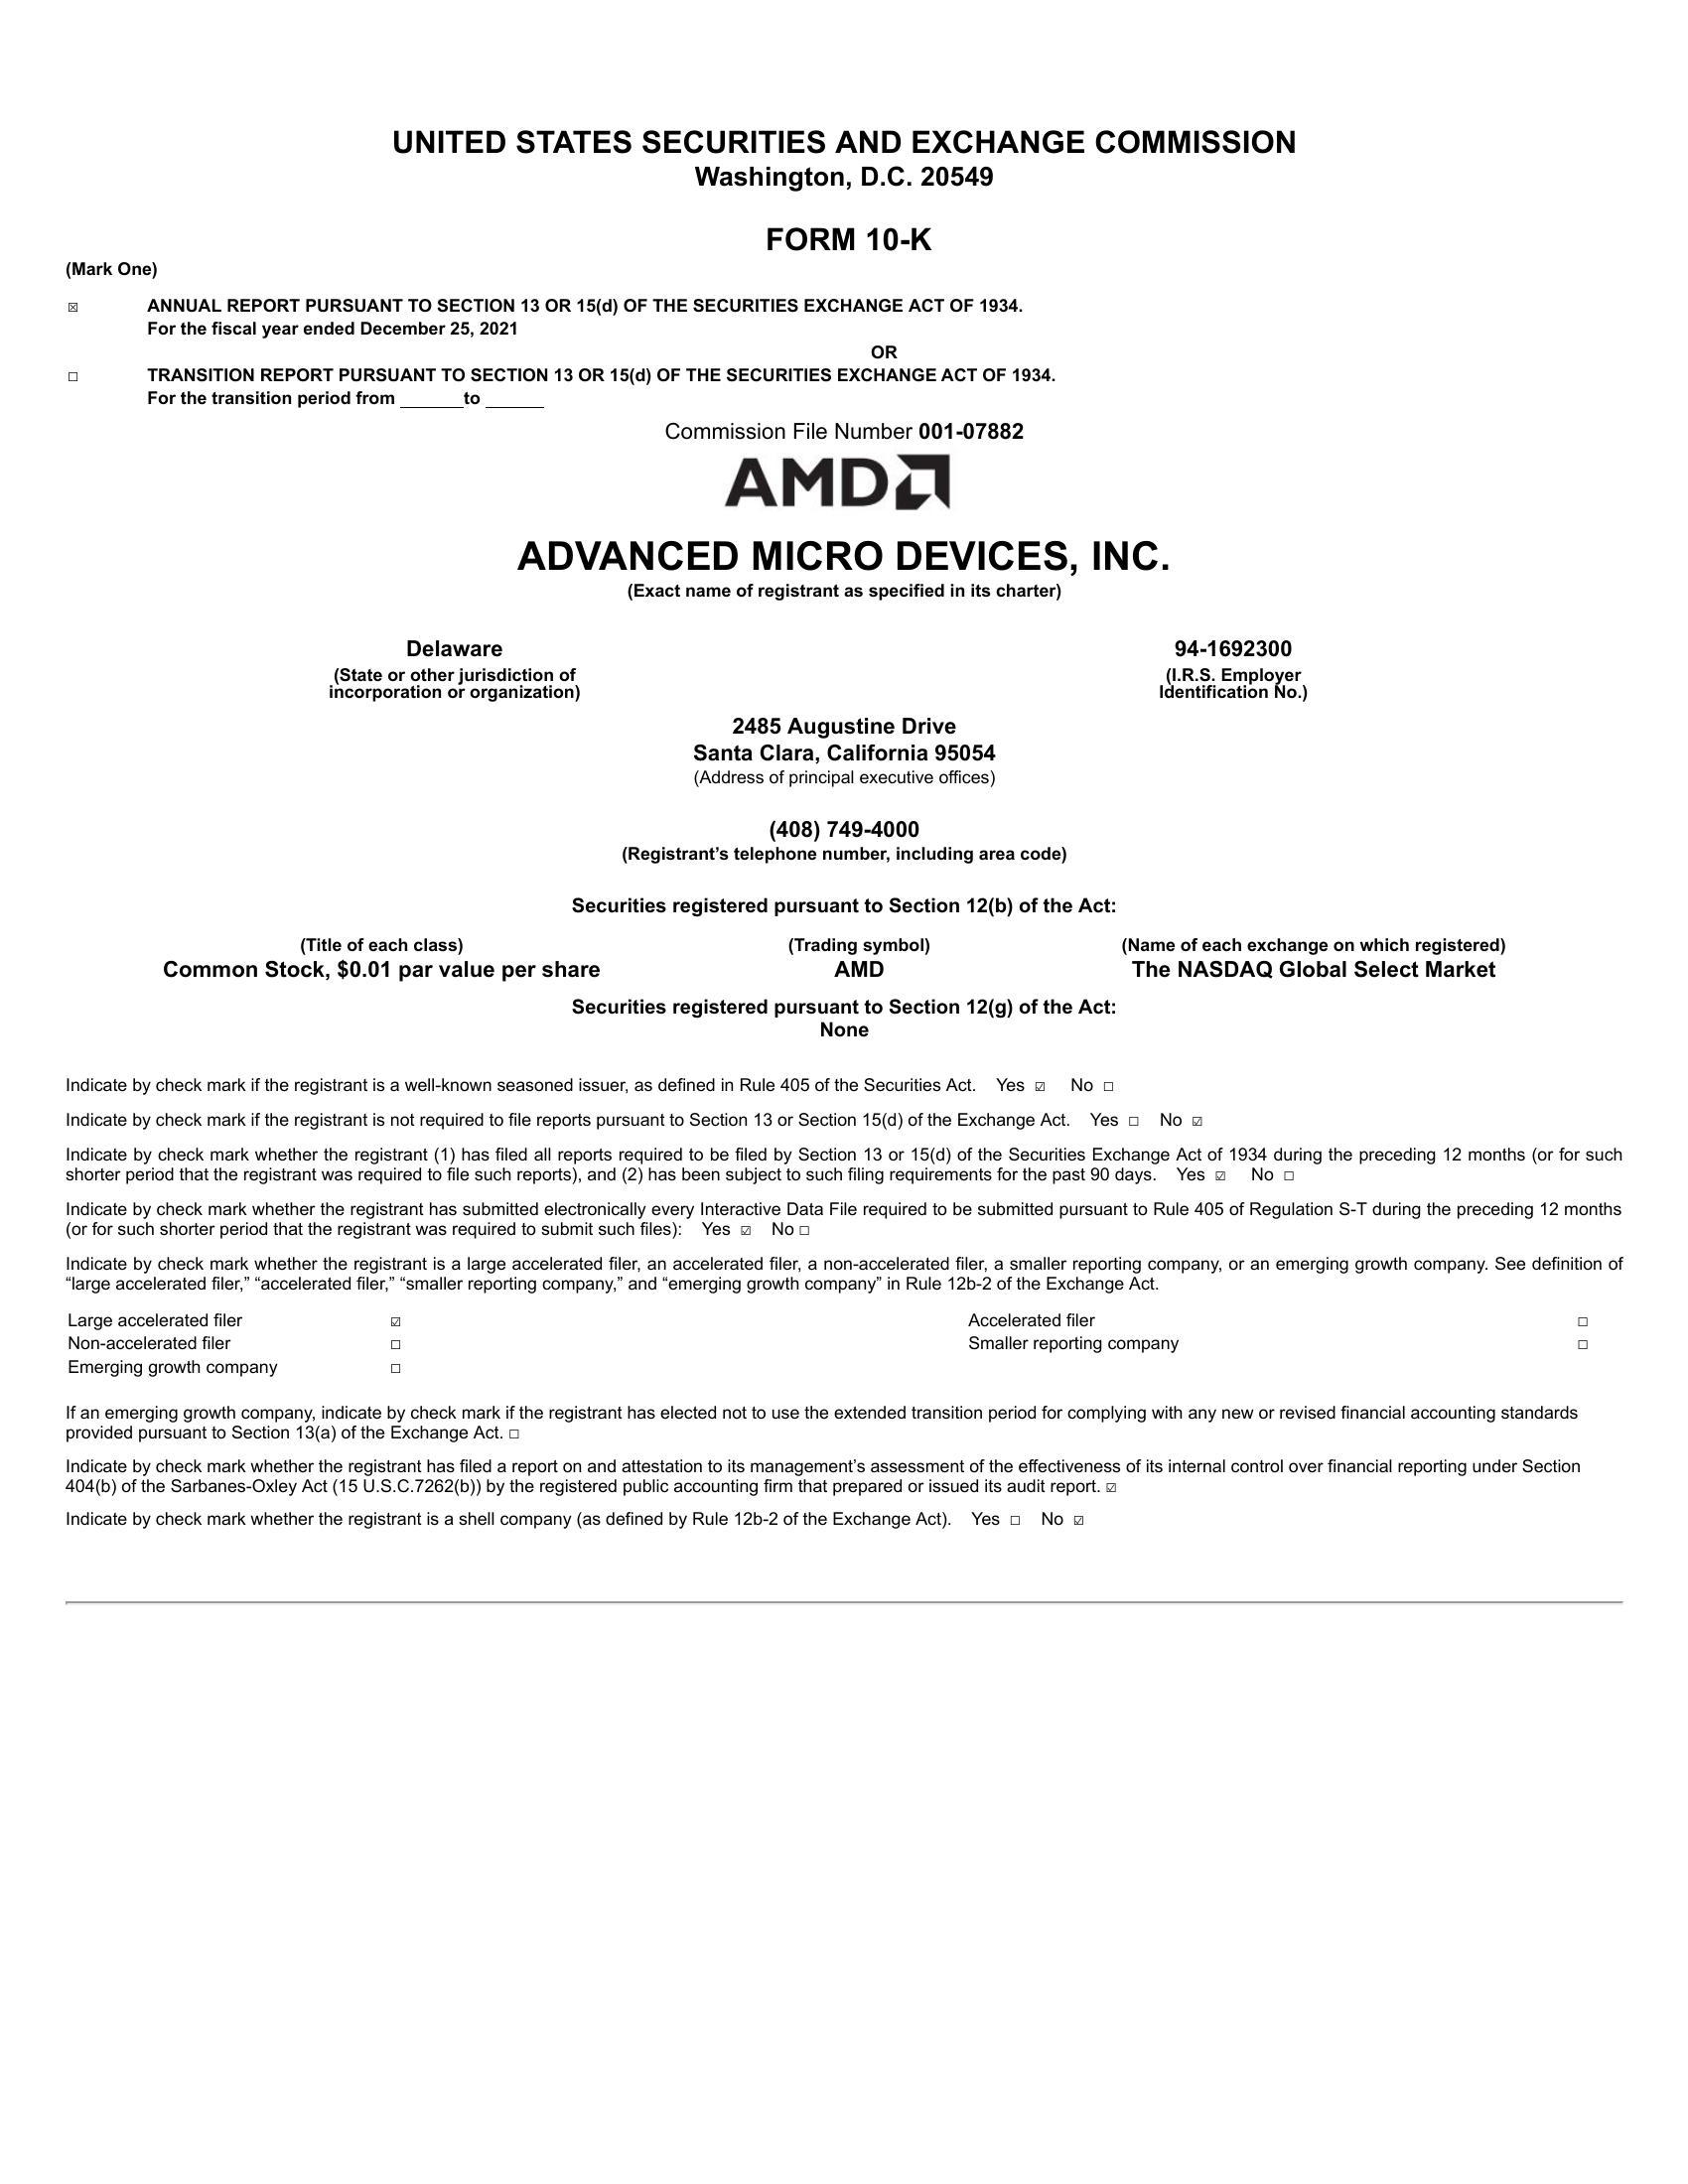

In [ ]:
from pdf2image import convert_from_path
images = convert_from_path("10k_report.pdf")
images[0]

In [ ]:
len(images)

118

This document has 188 pages, which is very big to run through any model. We will selct part of the document that contains relevant information. For example, the contents of the first paragraph os section "ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS", subsection "Overview":

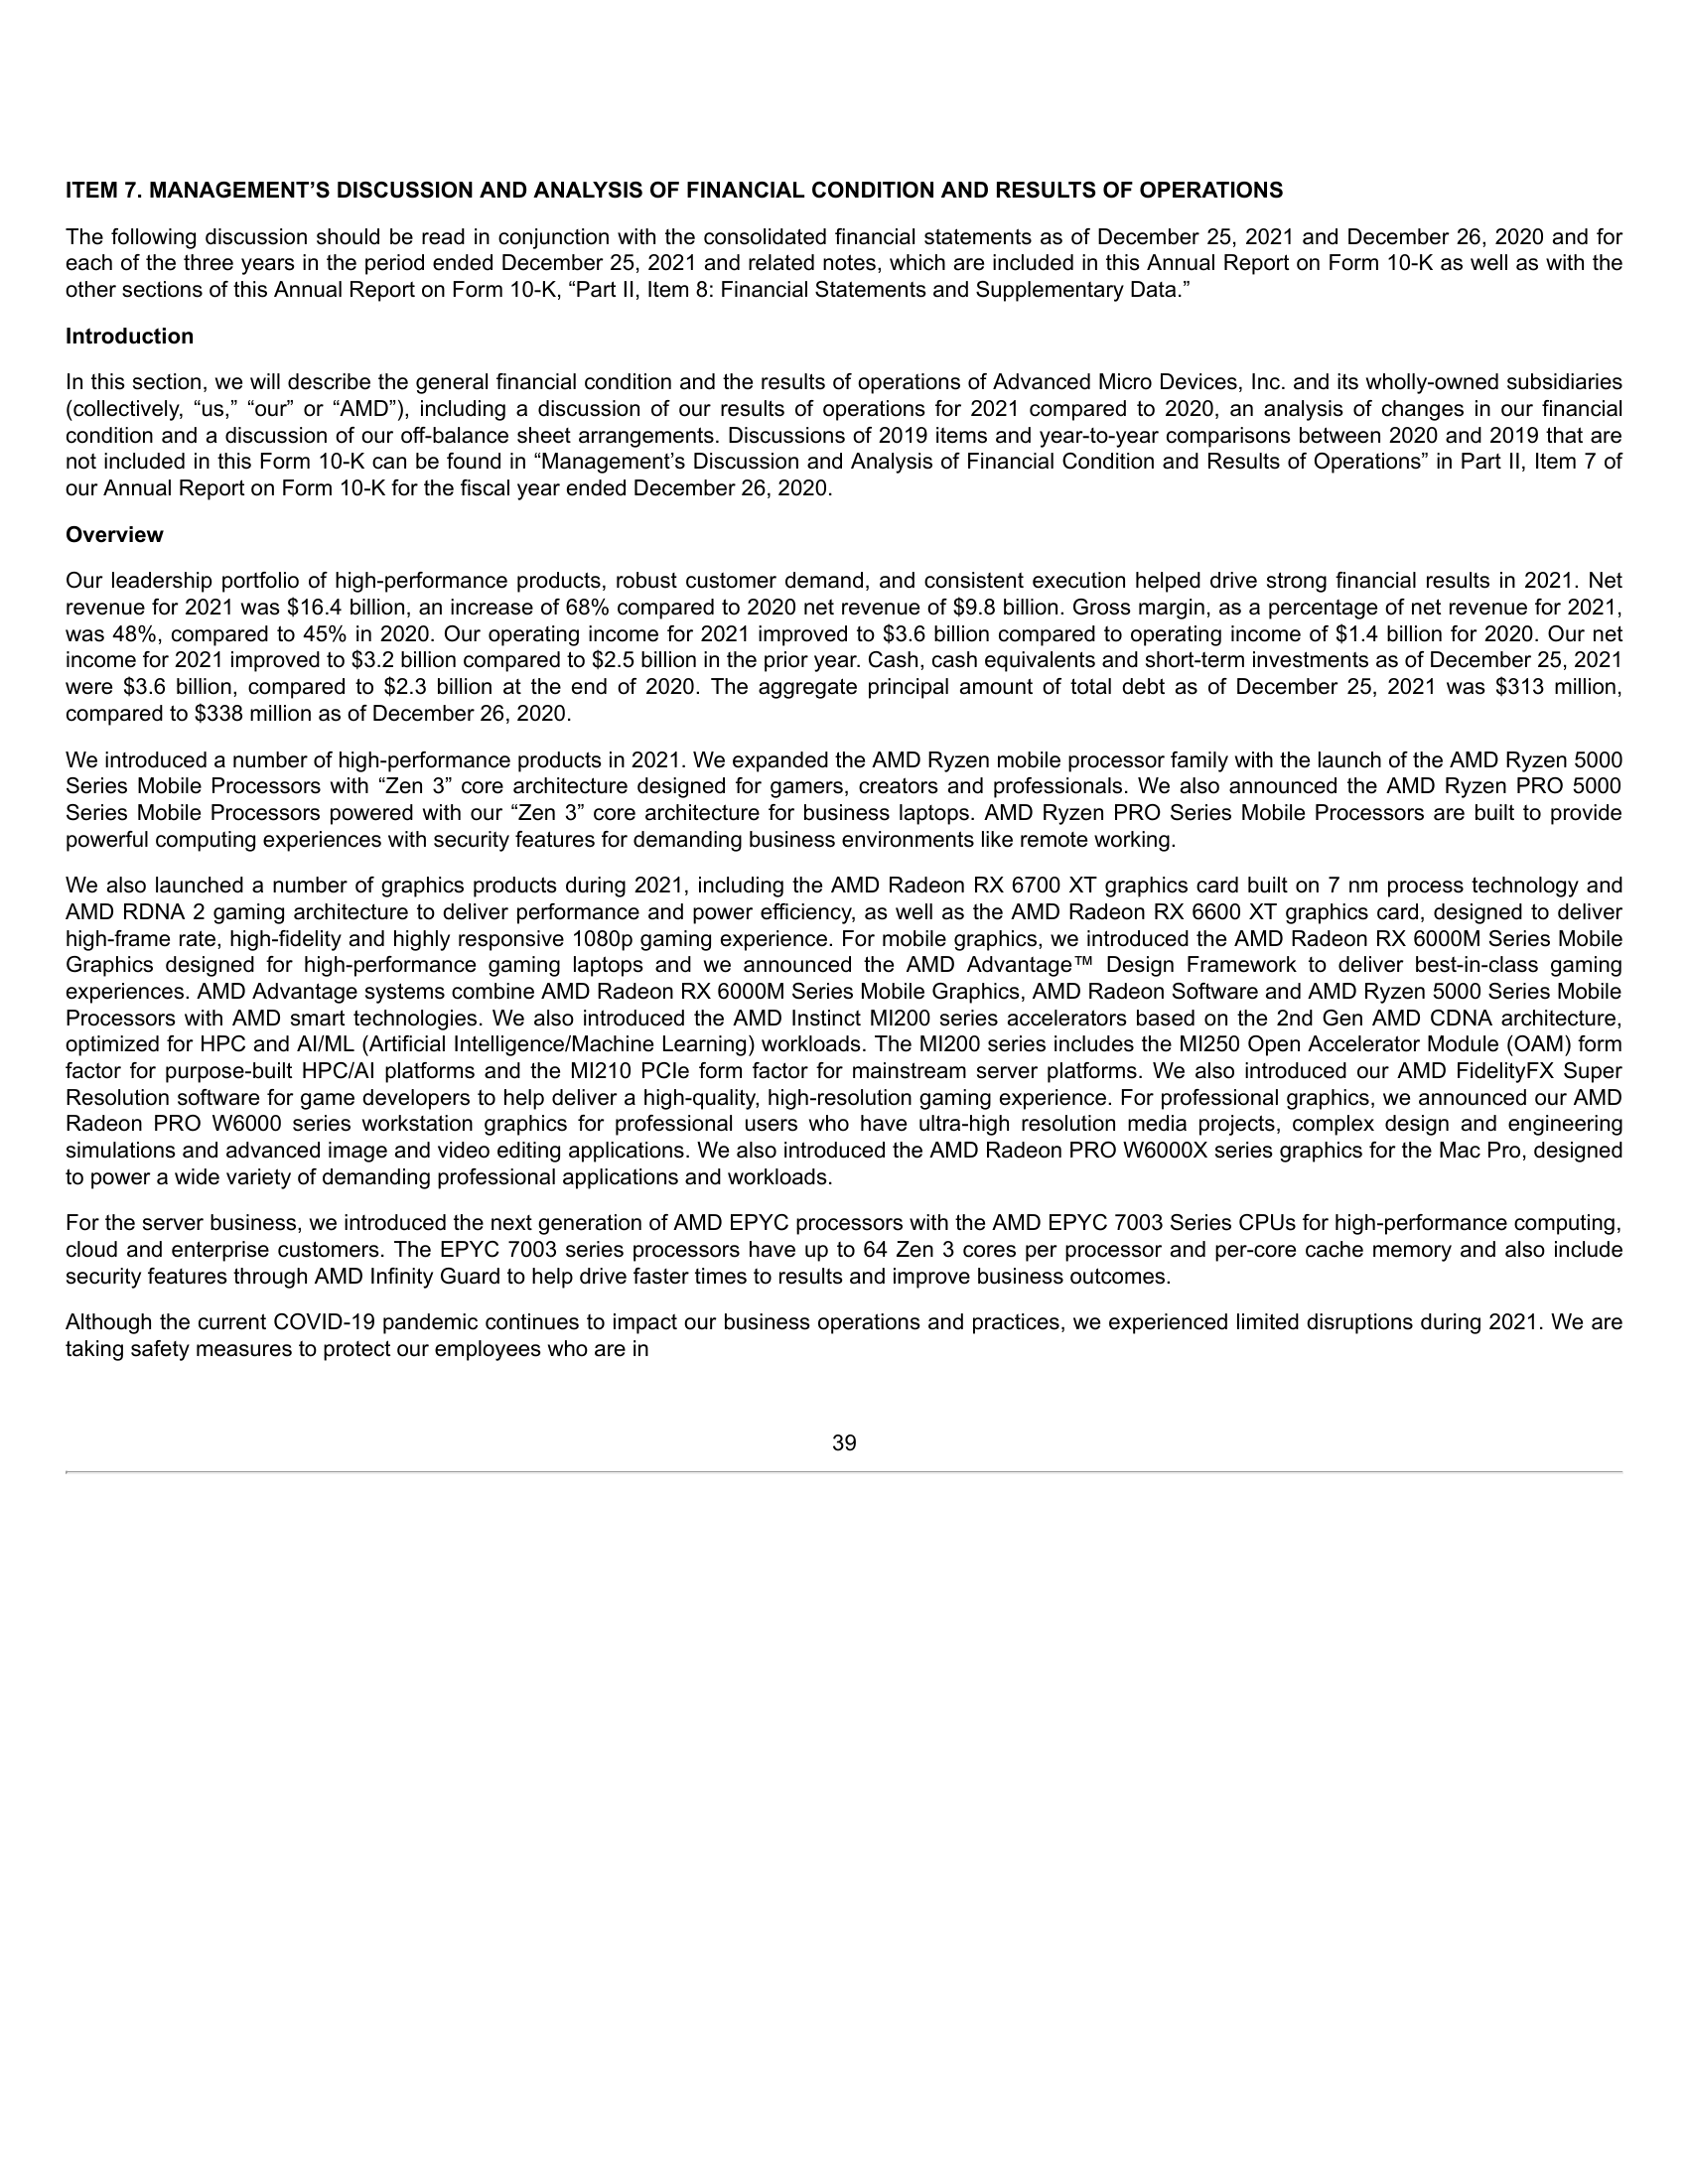

In [ ]:
images[41]

In [ ]:
text = """Our leadership portfolio of high-performance products, robust customer demand, and consistent execution helped drive strong financial results in 2021. Net
revenue for 2021 was $16.4 billion, an increase of 68% compared to 2020 net revenue of $9.8 billion. Gross margin, as a percentage of net revenue for 2021,
was 48%, compared to 45% in 2020. Our operating income for 2021 improved to $3.6 billion compared to operating income of $1.4 billion for 2020. Our net
income for 2021 improved to $3.2 billion compared to $2.5 billion in the prior year. Cash, cash equivalents and short-term investments as of December 25, 2021
were $3.6 billion, compared to $2.3 billion at the end of 2020. The aggregate principal amount of total debt as of December 25, 2021 was $313 million,
compared to $338 million as of December 26, 2020.
"""
print(text)

Our leadership portfolio of high-performance products, robust customer demand, and consistent execution helped drive strong financial results in 2021. Net
revenue for 2021 was $16.4 billion, an increase of 68% compared to 2020 net revenue of $9.8 billion. Gross margin, as a percentage of net revenue for 2021,
was 48%, compared to 45% in 2020. Our operating income for 2021 improved to $3.6 billion compared to operating income of $1.4 billion for 2020. Our net
income for 2021 improved to $3.2 billion compared to $2.5 billion in the prior year. Cash, cash equivalents and short-term investments as of December 25, 2021
were $3.6 billion, compared to $2.3 billion at the end of 2020. The aggregate principal amount of total debt as of December 25, 2021 was $313 million,
compared to $338 million as of December 26, 2020.



There are also ways to make these splitting of the document in an automatic way by running classification models on the document to identify its sections. This kind of application is out of scope of this notebook, but more information can be found on the binary classifiers [here](https://nlp.johnsnowlabs.com/models?edition=Finance+NLP&language=en&task=Text+Classification).

The `finner_financial_large` model detects 15 entities in the SEC 10-K fillings:

- `AMOUNT`: Numeric amounts, not percentages
- `PERCENTAGE`: Numeric amounts which are percentages
- `CURRENCY`: The currency of the amount
- `FISCAL_YEAR`: A date which expresses which month the fiscal exercise was closed for a specific year
- `DATE`: Generic dates in context where either it's not a fiscal year or it can't be asserted as such given the context
- `PROFIT`: Profit or also Revenue
- `PROFIT_INCREASE`: A piece of information saying there was a profit / revenue increase in that fiscal year
- `PROFIT_DECLINE`: A piece of information saying there was a profit / revenue decrease in that fiscal year
- `EXPENSE`: An expense or loss
- `EXPENSE_INCREASE`: A piece of information saying there was an expense increase in that fiscal year
- `EXPENSE_DECREASE`: A piece of information saying there was an expense decrease in that fiscal year
- `CF`: Cash flow operations
- `CF_INCREASE`: A piece of information saying there was a cash flow increase
- `CF_DECREASE`: A piece of information saying there was a cash flow decrease
- `LIABILITY`: A mentioned liability in the text



Using the function we created above, we can load the model by calling it with the correct parameters.  

- [finner_financial_large](https://nlp.johnsnowlabs.com/2022/10/20/finner_financial_large_en.html) for the pretained model
- [bert_embeddings_sec_bert_base](https://nlp.johnsnowlabs.com/2022/04/12/bert_embeddings_sec_bert_base_en_3_0.html) for the pretrained embeddings



In [ ]:
model = create_pipeline(
    ner_model="finner_financial_large",
    embeddings="bert_embeddings_sec_bert_base",
    language="en",
)
model.stages

sentence_detector_dl download started this may take some time.
Approximate size to download 514.9 KB
[OK!]
bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]
finner_financial_large download started this may take some time.
[OK!]


[DocumentAssembler_ba9ba1ce78c2,
 SentenceDetectorDLModel_8aaebf7e098e,
 REGEX_TOKENIZER_2c1d06668897,
 BERT_EMBEDDINGS_29ce72cd673e,
 FinanceNerModel_aa3d475c7801,
 NER_CONVERTER_4ddf4d4a15bd]

In [ ]:
# Check classes
model.stages[4].getClasses()

['O',
 'B-PERCENTAGE',
 'I-FISCAL_YEAR',
 'B-PROFIT_INCREASE',
 'B-CURRENCY',
 'B-EXPENSE_INCREASE',
 'I-PROFIT_INCREASE',
 'B-AMOUNT',
 'I-CURRENCY',
 'B-DATE',
 'I-PROFIT',
 'I-EXPENSE_DECREASE',
 'B-CF_INCREASE',
 'I-CF_DECREASE',
 'B-FISCAL_YEAR',
 'I-EXPENSE_INCREASE',
 'I-CF',
 'B-CF',
 'B-EXPENSE_DECREASE',
 'I-AMOUNT',
 'I-DATE',
 'I-PROFIT_DECLINE',
 'I-EXPENSE',
 'I-LIABILITY',
 'B-LIABILITY',
 'I-PERCENTAGE',
 'B-EXPENSE',
 'B-PROFIT_DECLINE',
 'B-PROFIT',
 'I-CF_INCREASE',
 'B-CF_DECREASE']

Let's test the model in an example text:

In [ ]:
df = spark.createDataFrame([[text]]).toDF("text")

result = model.transform(df)

Visualizing the identified entities in the `ner` column:

In [ ]:
result.select(
    F.explode(
        F.arrays_zip(result.token.result, result.ner.result, result.ner.metadata)
    ).alias("cols")
).select(
    F.expr("cols['0']").alias("token"),
    F.expr("cols['1']").alias("ner_label"),
    F.expr("cols['2']['confidence']").alias("confidence"),
).show(200, truncate=100)

+----------------+-------------+----------+
|           token|    ner_label|confidence|
+----------------+-------------+----------+
|             Our|            O|       1.0|
|      leadership|            O|    0.9978|
|       portfolio|            O|    0.9776|
|              of|            O|    0.9855|
|high-performance|            O|    0.9933|
|        products|            O|    0.7586|
|               ,|            O|    0.9999|
|          robust|            O|    0.9877|
|        customer|            O|    0.8912|
|          demand|            O|    0.7007|
|               ,|            O|    0.9998|
|             and|            O|    0.9998|
|      consistent|            O|    0.9834|
|       execution|            O|    0.8997|
|          helped|            O|       1.0|
|           drive|            O|    0.9998|
|          strong|            O|    0.9999|
|       financial|            O|     0.875|
|         results|            O|    0.9842|
|              in|            O|

Checking the same entities after passing through `NerConverterInternal`:

In [ ]:
result.select(
    F.explode(F.arrays_zip(result.ner_chunk.result, result.ner_chunk.metadata)).alias(
        "cols"
    )
).select(
    F.expr("cols['0']").alias("chunk"),
    F.expr("cols['1']['entity']").alias("ner_label"),
    F.expr("cols['1']['confidence']").alias("confidence"),
).show(truncate=False)


+----------------+---------+----------+
|chunk           |ner_label|confidence|
+----------------+---------+----------+
|2021            |DATE     |0.9891    |
|Net
revenue     |PROFIT   |0.42905   |
|2021            |DATE     |0.9769    |
|$               |CURRENCY |0.9973    |
|16.4 billion    |AMOUNT   |0.99925   |
|2020            |DATE     |0.9497    |
|net revenue     |PROFIT   |0.4899    |
|$               |CURRENCY |0.9967    |
|9.8 billion     |AMOUNT   |0.99950004|
|Gross margin    |PROFIT   |0.70945   |
|2021            |DATE     |0.9871    |
|2020            |DATE     |0.9856    |
|operating income|PROFIT   |0.58795   |
|2021            |DATE     |0.9875    |
|$               |CURRENCY |0.9995    |
|3.6 billion     |AMOUNT   |0.9997    |
|operating income|PROFIT   |0.70165   |
|$               |CURRENCY |0.999     |
|1.4 billion     |AMOUNT   |0.99965   |
|2020            |DATE     |0.9819    |
+----------------+---------+----------+
only showing top 20 rows



Using the visualization package:

In [ ]:
ner_visualizer = viz.NerVisualizer()

In [ ]:
ner_visualizer.display(
    result.collect()[0], label_col="ner_chunk", document_col="document"
)

### Using LightPipeline

[LightPipelines](https://nlp.johnsnowlabs.com/docs/en/concepts#using-spark-nlps-lightpipeline) are Spark NLP specific Pipelines, equivalent to Spark ML Pipeline, but meant to deal with smaller amounts of data. They’re useful working with small datasets, debugging results, or when running either training or prediction from an API that serves one-off requests.

Spark NLP LightPipelines are Spark ML pipelines converted into a single machine but the multi-threaded task, **becoming more than 10x times faster** for smaller amounts of data (small is relative, but 50k sentences are roughly a good maximum). To use them, we simply plug in a trained (fitted) pipeline and then annotate a plain text. We don't even need to convert the input text to DataFrame in order to feed it into a pipeline that's accepting DataFrame as an input in the first place. This feature would be quite useful when it comes to getting a prediction for a few lines of text from a trained ML model.

For more details:
[https://medium.com/spark-nlp/spark-nlp-101-lightpipeline-a544e93f20f1](https://medium.com/spark-nlp/spark-nlp-101-lightpipeline-a544e93f20f1)

In [ ]:
light_model = nlp.LightPipeline(model)

You can use strings or list of strings with the method [.annotate()](https://nlp.johnsnowlabs.com/api/python/reference/autosummary/sparknlp/base/light_pipeline/index.html#sparknlp.base.light_pipeline.LightPipeline.annotate) to get the results. To get more metadata in the result, use the method [.fullAnnotate()](https://nlp.johnsnowlabs.com/api/python/reference/autosummary/sparknlp/base/light_pipeline/index.html#sparknlp.base.light_pipeline.LightPipeline.fullAnnotate) instead. The result is a `list` if a `list` is given, or a `dict` if a string was given.

To extract the results from the object, you just need to parse the dictionary.

In [ ]:
lp_results = light_model.annotate(text)
lp_results.keys()

dict_keys(['document', 'ner_chunk', 'token', 'ner', 'embeddings', 'sentence'])

In [ ]:
# List with all the chunks
lp_results["ner_chunk"]

['2021',
 'Net\nrevenue',
 '2021',
 '$',
 '16.4 billion',
 '2020',
 'net revenue',
 '$',
 '9.8 billion',
 'Gross margin',
 '2021',
 '2020',
 'operating income',
 '2021',
 '$',
 '3.6 billion',
 'operating income',
 '$',
 '1.4 billion',
 '2020',
 'net\nincome',
 '2021',
 '$',
 '3.2 billion',
 '$',
 '2.5 billion',
 'Cash, cash equivalents and short-term investments',
 'December 25, 2021',
 '$',
 '3.6 billion',
 '$',
 '2.3 billion',
 '2020',
 'total debt',
 'December 25, 2021',
 '$',
 '313 million',
 '$',
 '338 million',
 'December 26, 2020']

We can see that the `.annotate()` did't return the labels in the `ner_chunk` item. How can we obtain them? Using the `.fullAnnotate()` instead. This method always returns a list.

In [ ]:
lp_results_full = light_model.fullAnnotate(text)
lp_results_full[0].keys()

dict_keys(['document', 'ner_chunk', 'token', 'ner', 'embeddings', 'sentence'])

In [ ]:
lp_results_full[0]["ner_chunk"]

[Annotation(chunk, 145, 148, 2021, {'chunk': '0', 'confidence': '0.9891', 'ner_source': 'ner_chunk', 'entity': 'DATE', 'sentence': '0'}),
 Annotation(chunk, 151, 161, Net
 revenue, {'chunk': '1', 'confidence': '0.42905', 'ner_source': 'ner_chunk', 'entity': 'PROFIT', 'sentence': '1'}),
 Annotation(chunk, 167, 170, 2021, {'chunk': '2', 'confidence': '0.9769', 'ner_source': 'ner_chunk', 'entity': 'DATE', 'sentence': '1'}),
 Annotation(chunk, 176, 176, $, {'chunk': '3', 'confidence': '0.9973', 'ner_source': 'ner_chunk', 'entity': 'CURRENCY', 'sentence': '1'}),
 Annotation(chunk, 177, 188, 16.4 billion, {'chunk': '4', 'confidence': '0.99925', 'ner_source': 'ner_chunk', 'entity': 'AMOUNT', 'sentence': '1'}),
 Annotation(chunk, 222, 225, 2020, {'chunk': '5', 'confidence': '0.9497', 'ner_source': 'ner_chunk', 'entity': 'DATE', 'sentence': '1'}),
 Annotation(chunk, 227, 237, net revenue, {'chunk': '6', 'confidence': '0.4899', 'ner_source': 'ner_chunk', 'entity': 'PROFIT', 'sentence': '1'}),
 A

Now we can see all the metadata in the annotation objects. Let's get the results in a tabular form.

In [ ]:
results_tabular = []
for res in lp_results_full[0]["ner_chunk"]:
    results_tabular.append(
        (
            res.begin,
            res.end,
            res.result,
            res.metadata["entity"],
            res.metadata["confidence"],
        )
    )

import pandas as pd

pd.DataFrame(results_tabular, columns=["begin", "end", "chunk", "entity", "confidence"])


,begin,end,chunk,entity,confidence
0,145,148,2021,DATE,0.9891
1,151,161,Net\nrevenue,PROFIT,0.42905
2,167,170,2021,DATE,0.9769
3,176,176,$,CURRENCY,0.9973
4,177,188,16.4 billion,AMOUNT,0.99925
5,222,225,2020,DATE,0.9497
6,227,237,net revenue,PROFIT,0.4899
7,242,242,$,CURRENCY,0.9967
8,243,253,9.8 billion,AMOUNT,0.99950004
9,256,267,Gross margin,PROFIT,0.70945


## BertForTokenClassification

BertForTokenClassification can load Bert Models with a token classification head on top (a linear layer on top of the hidden-states output) e.g. for Named-Entity-Recognition (NER) tasks.

Models from the HuggingFace 🤗 Transformers library are also compatible with Spark NLP 🚀. To see which models are compatible and how to import them see [Import Transformers into Spark NLP 🚀](https://github.com/JohnSnowLabs/spark-nlp/discussions/5669).

Using these models is very similar to the `NerModel` we used before. We adjust the pipeline by adding the `BertForTokenClassification` step instead of `NerModel`, and don't need to add the `Embeddings` step as it is already part of the new annotator. 

Then, the pipeline is just:

In [ ]:
def bert_pipeline(model_name="finner_roberta_ticker", language="en"):
    documentAssembler = (
        nlp.DocumentAssembler().setInputCol("text").setOutputCol("document")
    )

    tokenizer = nlp.Tokenizer().setInputCols("document").setOutputCol("token")

    tokenClassifier = (
        nlp.RoBertaForTokenClassification.pretrained(
            "finner_roberta_ticker", "en", "finance/models"
        )
        .setInputCols(["document", "token"])
        .setOutputCol("label")
    )

    ner_converter = (
        finance.NerConverterInternal()
        .setInputCols(["document", "token", "label"])
        .setOutputCol("ner_chunk")
    )

    pipeline = nlp.Pipeline(
        stages=[documentAssembler, tokenizer, tokenClassifier, ner_converter]
    )

    empty_data = spark.createDataFrame([[""]]).toDF("text")

    model = pipeline.fit(empty_data)
    return model

For Finance NLP we currently have only one model available, but we are constantly adding new models with every release. The available model is the `finner_bert_roles`, which identifies roles in financial texts (trained on Wikipedia articles, CUAD dataset, Financial 10-K documents and resumes.

In [ ]:
bert_model = bert_pipeline("finner_roberta_ticker", "en")
bert_model.stages

finner_roberta_ticker download started this may take some time.
Approximate size to download 443.8 MB
[OK!]


[DocumentAssembler_1cff0935ec46,
 REGEX_TOKENIZER_b6c88c096c31,
 RoBertaForTokenClassification_e2cf221f8e7e,
 NER_CONVERTER_482a5358eca4]

In [ ]:
text = "Trading Guide: MRPL, SBI among 7 stock recommendations for Tuesday​"

res = bert_model.transform(spark.createDataFrame([[text]]).toDF("text"))

result_df = res.select(
    F.explode(
        F.arrays_zip(res.ner_chunk.result, res.ner_chunk.metadata)
    ).alias("cols")
).select(
     F.expr("cols['0']").alias("chunk"),
    F.expr("cols['1']['entity']").alias("ner_label"),
    F.expr("cols['1']['confidence']").alias("confidence"),
)

result_df.show(50, truncate=100)

+-----+---------+----------+
|chunk|ner_label|confidence|
+-----+---------+----------+
| MRPL|   TICKER|0.99974465|
|  SBI|   TICKER| 0.9999046|
+-----+---------+----------+

